In [22]:
from diffusers import AutoencoderKL
import torch
from PIL import Image
import numpy as np
from torch.cuda.amp import autocast

In [25]:
torch_device = "cuda"
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(torch_device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [26]:
@torch.no_grad()
def to_latents(img:Image):
  np_img = (np.array(img).astype(np.float32) / 255.0) * 2.0 - 1.0
  np_img = np_img[None].transpose(0, 3, 1, 2)
  torch_img = torch.from_numpy(np_img)
  with autocast():
    generator = torch.Generator("cuda").manual_seed(0)
    latents = vae.encode(torch_img.to(vae.dtype).to(torch_device)).latent_dist.sample(generator=generator)
  return latents

In [27]:
@torch.no_grad()
def to_img(latents):
  with autocast():
    torch_img = vae.decode(latents.to(vae.dtype).to(torch_device)).sample
  torch_img = (torch_img / 2 + 0.5).clamp(0, 1)
  np_img = torch_img.cpu().permute(0, 2, 3, 1).detach().numpy()[0]
  np_img = (np_img * 255.0).astype(np.uint8)
  img = Image.fromarray(np_img)
  return img

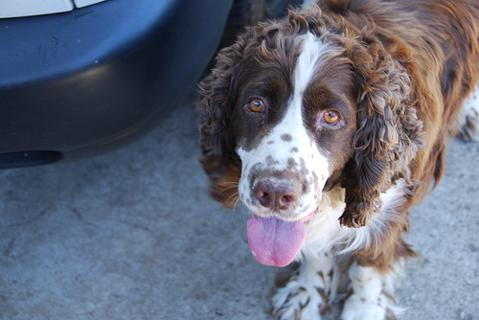

In [119]:
img = Image.open("imagenette/train/n02102040/ILSVRC2012_val_00000665.JPEG")
img.save("orig.png")
img

In [135]:
z = to_latents(img)
E = z.mean()
m = z.min()
M = z.max()
z = 16*(z-m)/(M-m)
z = z.int()
z = z.double()
z = z*(M-m)/16
z = z+m

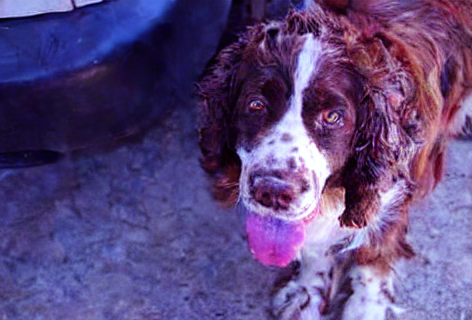

In [140]:
to_img(z).save("compressed.png")
to_img(z)

New compression ratio is

In [141]:
(8/4)*np.prod(np.shape(img))/np.prod(np.shape(z))

97.42372881355932

Image was originally a 24KB JPEG with compression ratio

In [139]:
np.prod(np.shape(img))/(24000)

19.16